In [1]:
import torch
import torch.nn as nn
from base.data import get_data_loaders, get_data_loaders_wandb, get_data_loaders_loocv
from base.train import Trainer, eval_metrics
import pandas as pd
import wandb
import matplotlib.pyplot as plt

In [2]:
class MLPHead(nn.Module):
    def __init__(self, in_dim, out_dim, use_norm, dropout, n_layers):
        super(MLPHead, self).__init__()
        l_sz = [in_dim] + [in_dim//2**(i+1) for i in range(n_layers)] + [out_dim]
        layers = []
        for i in range(1, len(l_sz)-1):
            layers.append(nn.Linear(l_sz[i-1], l_sz[i]))
            if use_norm == 'batch':
                layers.append(nn.BatchNorm1d(l_sz[i]))
            elif use_norm == 'layer':
                layers.append(nn.LayerNorm(l_sz[i]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        layers.append(nn.Linear(l_sz[-2], l_sz[-1]))
        self.head = nn.Sequential(*layers)

    def forward(self, x):
        return self.head(x)

In [3]:
class MLP(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.n_embeddings = cfg['n_embeddings']
        self.projection = nn.Sequential(
            nn.Linear(cfg['emb_dim'], cfg['emb_latent_dim']),
            nn.LayerNorm(cfg['emb_latent_dim'])
        )
        # in_dim = cfg['emb_latent_dim'] * self.n_embeddings + cfg['transf_dim']
        in_dim = cfg['emb_latent_dim'] * (self.n_embeddings[0] + self.n_embeddings[1]) + cfg['transf_dim']
        out_dim = 1 if cfg['task'] == 'regression' else cfg['num_classes']
        self.head = MLPHead(in_dim, out_dim, cfg['use_layer_norm'], cfg['dropout'], cfg['n_hid_layers'])

    # ENB1: unmodified code
    # EMB2: mutated code
    def forward(self, batch):
        if self.n_embeddings[0]:
            em_feat_1 = self.projection(batch[0])
            if self.n_embeddings[1] == True:
                em_feat_2 = self.projection(batch[1])
                if self.n_embeddings[2]:
                    x = torch.cat([em_feat_1, em_feat_2, batch[2]], dim=1)
                else:
                    x = torch.cat([em_feat_1, em_feat_2], dim=1)
            else:
                if self.n_embeddings[2]:
                    x = torch.cat([em_feat_1, batch[1]], dim=1)
                else:
                    x = em_feat_1
        else:
            if self.n_embeddings[1]:
                em_feat_2 = self.projection(batch[0])
                if self.n_embeddings[2]:
                    x = torch.cat([em_feat_2, batch[1]], dim=1)
                else:
                    x = em_feat_2
        return self.head(x).squeeze(-1)

        # Old version:
        # (EMB1, TRANSF) (case 1)
        # (EMB1, EMB2, TRANSF) (case 2)
        
        # em_feat_1 = self.projection(batch[0])
        # if self.n_embeddings == 1:
        #     x = torch.cat([em_feat_1, batch[1]], dim=1)
        # elif self.n_embeddings == 2:
        #     em_feat_2 = self.projection(batch[1])
        #     x = torch.cat([em_feat_1, em_feat_2, batch[2]], dim=1)
        # return self.head(x).squeeze(-1)

In [4]:
# Show a histogram of the train test split sizes for the number of training data points and validation data points
def visualize_loocv_splits(loaders):
    train_sizes = [len(tr_loader.dataset) for _, tr_loader, _ in loaders]
    val_sizes = [len(va_loader.dataset) for _, _, va_loader in loaders]

    x = range(1, len(train_sizes) + 1)
    width = 0.35

    fig, ax = plt.subplots()
    bars1 = ax.bar(x, train_sizes, width, label='Train')
    bars2 = ax.bar([p + width for p in x], val_sizes, width, label='Validation')

    ax.set_xlabel('Fold Number and val Application Name')
    ax.set_ylabel('Number of Data Points')
    ax.set_title('Train and Validation Sizes per Fold')

    # Add application names to the fold numbers
    app_names = [app for app, _, _ in loaders]
    ax.set_xticks([p + width/2 for p in x])
    ax.set_xticklabels([f'{i}\n{app}' for i, app in zip(x, app_names)])

    ax.legend()

    # Set y-axis to logarithmic scale
    ax.set_yscale('log')

    # Add numbers at the top of each bar
    for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom')

    for bar in bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom')

    plt.show()

## Main Project Pipeline

In [4]:
class ExperimentRunner:
    def __init__(self, cfg_data, device, load_data=True):
        self.cfg_data = cfg_data
        self.device = device
                
    def _initialize_model(self, cfg_model):
        if cfg_model['model_type'] == 'attention':
            self.model = BidirectionalCrossAttention(cfg_model).to(self.device)
        elif cfg_model['model_type'] == 'mlp':
            self.model = MLP(cfg_model).to(self.device)
        print("\n", self.model)

    def train_model(self, cfg_model):
        self.trainer = Trainer(self.device, self.model, cfg_model)
        tr_losses, va_losses = self.trainer.train(self.tr_loader, self.va_loader)
        self.model.load_state_dict(torch.load('best_model.pth', weights_only=True))
        wandb.log({"training_loss": tr_losses[-1], "validation_loss": va_losses[-1]})
        return tr_losses, va_losses

    def evaluate_model(self, loader, dataset_type):
        preds, tgts = self.trainer.predict(loader)
        mapping = loader.dataset.loop_mapping if self.cfg_data['min_transformations'] > 2 else None
        unique_classes = tgts.unique().tolist()
        active_classes = [self.cfg_data['classes'][i] for i in unique_classes]
        metrics = eval_metrics(
            preds, tgts, figures=True, mapping=mapping, type=self.cfg_data['task'],
            classes=active_classes
        )
        print(f"{dataset_type} metrics: {metrics}")
        wandb.log({f"{dataset_type}_metrics": metrics})

    def run(self, project_name, group_name, run_name_prefix, count=1):
        for i in range(count):
            wandb.init(
                project=project_name, 
                group=group_name,
                name=f"{run_name_prefix}_{i+1}",
                config={**self.cfg_data},
            )
            self.tr_loader, self.va_loader = get_data_loaders_wandb(self.cfg_data)
            self.run_experiment()
    
    def run_loocv(self, project_name, group_name, run_name_prefix):
        loaders = get_data_loaders_loocv(self.cfg_data)
        # visualize_loocv_splits(loaders) # create a visualization of the train and validation sizes per fold
        for i, (val_app, tr_loader, va_loader) in enumerate(loaders):
            print(f'Fold {i+1} - Validation on {val_app}')
            # update the loaders for the current fold
            self.tr_loader = tr_loader
            self.va_loader = va_loader
            print(f'Training on {len(self.tr_loader.dataset)} samples')
            print(f'Validating on {len(self.va_loader.dataset)} samples')
            wandb.init(
                project=project_name, 
                group=group_name,
                name=f"{run_name_prefix}_fold_{i+1}_{val_app}",
                config={**self.cfg_data},
            )
            self.run_experiment()
        
    def run_experiment(self):
        cfg_model = {
            'n_hid_layers': 3,
            'n_embeddings': self.cfg_data['n_embeddings'],
            'emb_dim': self.tr_loader.dataset.embed_dim, # embedding dimensionality
            'emb_latent_dim': 256, # embedding projection dimensionality
            'transf_dim': self.tr_loader.dataset.tr_dim, # transformation dimensionality
            'model_type': 'mlp', # 'attention', 'mlp'
            'task': self.cfg_data['task'],
            'dropout': 0.2,
            'learning_rate': 1e-3,
            'use_layer_norm': 'batch',
            'weight_decay': 1e-3,
            'max_epochs': 100,
            'num_classes': len(self.cfg_data['classes'])
        }
        wandb.config.update(cfg_model)
        self._initialize_model(cfg_model)
        self.train_model(cfg_model)
        self.evaluate_model(self.tr_loader, 'train')
        self.evaluate_model(self.va_loader, 'val')
        wandb.finish()
        
    def run_sweep(self, sweep_id, project_name, group_name, run_name_prefix, count=10):
        def sweep_function():
            wandb.init(
                project=project_name, 
                group=group_name,
                config={**self.cfg_data},
            )
            run_name = f"{run_name_prefix}_{wandb.run.id}" # update sweep run name
            wandb.run.name = run_name   
            self.run_sweep_experiment()
            
        self.tr_loader, self.va_loader = get_data_loaders_wandb(self.cfg_data)
        wandb.agent(sweep_id, sweep_function, count=count)

    def run_sweep_experiment(self):
        # Build model configuration from wandb.config
        cfg_model = {
            'n_hid_layers': wandb.config.n_hid_layers,
            'n_embeddings': self.cfg_data['n_embeddings'],
            'emb_dim': self.tr_loader.dataset.embed_dim,
            'emb_latent_dim': wandb.config.emb_latent_dim,
            'transf_dim': self.tr_loader.dataset.tr_dim,
            'model_type': wandb.config.model_type,
            'task': self.cfg_data['task'],
            'dropout': wandb.config.dropout,
            'learning_rate': wandb.config.learning_rate,
            'use_layer_norm': wandb.config.use_layer_norm,
            'weight_decay': wandb.config.weight_decay,
            'max_epochs': wandb.config.max_epochs,
            'num_classes': len(self.cfg_data['classes'])
        }
        self._initialize_model(cfg_model)
        self.train_model(cfg_model)
        self.evaluate_model(self.tr_loader, 'train')
        self.evaluate_model(self.va_loader, 'val')
        wandb.finish()

In [5]:
cfg_data = {
    'n_workers': 32,
    'batch_size': 2048,    
    'stratification': 'majority', # 'random', 'binary', 'clustered', 'majority'
    'data_path': '/mnt/fastdata/datasets/lore-loops/web-clang',
    'embedding_model': 'source_coderankembed', # 'llvm_llmcompiler', 'source_codellama', 'source_llmcompiler', 'source_codet5p', 'source_coderankembed'
    'embedding_layer': 'last', # 'last', 'all' (not working yet)
    'n_embeddings': [1, 0, 1], # binary flags for [ref_embedding, transformation_embedding, transformation_encoding]
    'min_transformations': 1, # only loop groups with at least <min> transformations
    'max_transformations': 10000, # only loop groups with at most <max> transformations
    'max_speedup': 2.5, # remove any loop group with a speedup transformation > max_speedup
    'max_source_size': 100000, # only loop groups where reference .C file is at most <max> bytes
    'task': 'classification',  # 'classification', 'regression'
    # [(0, np.float64(0.5)), (2, np.float64(1.5)), (4, np.float64(2.5)), (6, np.float64(3.5))]
    'class_splits': [0, .7, 1, 1.5, 17],
    # 'class_splits': [-100, .5, 0.9999, 1.0001, 1.5, 2.5, 3.5, 100000],
    'classes': ['HSL', 'SL', 'SP', 'HSP'],
    'seed': 4,
    'csv_path': './clang_4.0.0_data_table.csv', # for new data loader
    'benchmark': '',
    'filters': [],
}

In [6]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda:0


### Hyperparameter Sweep Testing

In [ ]:
sweep_config = {
    'method': 'random',  # 'random', 'grid', 'bayes'
    'metric': {'name': 'validation_loss', 'goal': 'minimize'},
    'parameters': {
        'n_hid_layers': {'values': [1, 2, 3, 4]},
        'emb_latent_dim': {'values': [128, 256, 512]},
        'model_type': {'value': 'mlp'},
        'dropout': {'min': 0.1, 'max': 0.5},
        'learning_rate': {'min': 1e-5, 'max': 1e-2},
        'use_layer_norm': {'values': ['batch', 'layer', None]},
        'weight_decay': {'min': 1e-5, 'max': 1e-3},
        'max_epochs': {'value': 100},
    }
}

sweep_id = wandb.sweep(sweep_config, project='MLFinal')

runner = ExperimentRunner(cfg_data, device)
runner.run_sweep(
    sweep_id, 
    project_name='MLFinal', 
    group_name='All data, Experiment 5c (Random Sweep)', 
    run_name_prefix='exp5b_run', 
    count=20
)

### LOOCV Testing

In [ ]:
cfg_data.update({
    'benchmark': 'NPB',
    'filters': [('benchmark', '==', 'NPB')]
})

runner = ExperimentRunner(cfg_data, device, load_data=False)
runner.run_loocv(
    project_name='MLFinal', 
    group_name='LOOCV, NPB Benchmark', 
    run_name_prefix='exp2e', 
)

### Standard Testing

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ryanbrooks (ryanbrooks-uni). Use `wandb login --relogin` to force relogin


Loop groups stratified into Counter({'SL': 595, 'SP': 525, 'HSL': 416, 'HSP': 51})
Total loop groups: 1587 Train: 1269 Val: 318
768
56
44 loop groups removed for this split
768
56
7 loop groups removed for this split
Total datapoints: 69057 Train: 58783 Valid: 10274

 MLP(
  (projection): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (head): MLPHead(
    (head): Sequential(
      (0): Linear(in_features=312, out_features=156, bias=True)
      (1): BatchNorm1d(156, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=156, out_features=78, bias=True)
      (5): BatchNorm1d(78, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0.2, inplace=False)
      (8): Linear(in_features=78, out_features=39, bias=True)
      (9): BatchNorm1d(39, eps=1e-05

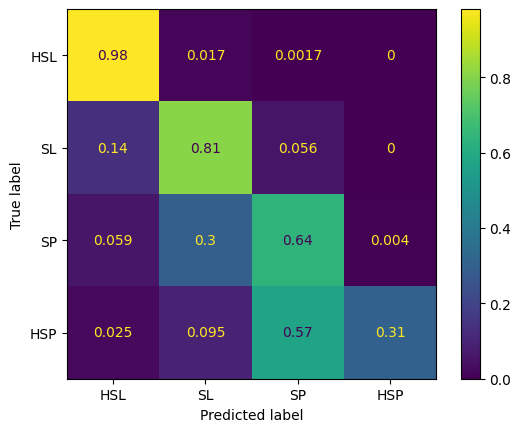

train metrics: {'num_unique_targets': 4, 'accuracy': 0.8880288600921631, 'speedup_slowdown_accuracy': 0.9906095266342163}


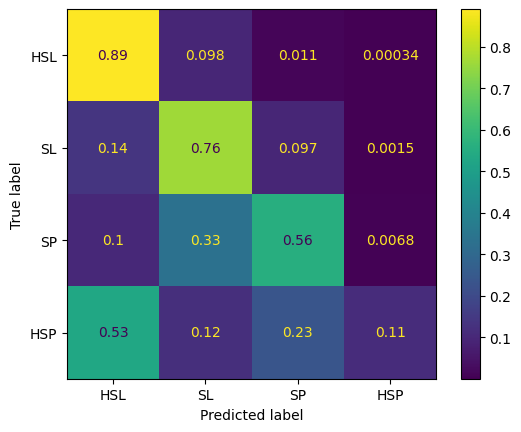

val metrics: {'num_unique_targets': 4, 'accuracy': 0.7923885583877563, 'speedup_slowdown_accuracy': 0.9832587242126465}


training_loss,▁
validation_loss,▁
training_loss,0.26084
validation_loss,0.56017


Loop groups stratified into Counter({'SL': 595, 'SP': 525, 'HSL': 416, 'HSP': 51})
Total loop groups: 1587 Train: 1269 Val: 318
768
56
44 loop groups removed for this split
768
56
7 loop groups removed for this split
Total datapoints: 69057 Train: 58783 Valid: 10274

 MLP(
  (projection): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (head): MLPHead(
    (head): Sequential(
      (0): Linear(in_features=312, out_features=156, bias=True)
      (1): BatchNorm1d(156, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=156, out_features=78, bias=True)
      (5): BatchNorm1d(78, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0.2, inplace=False)
      (8): Linear(in_features=78, out_features=39, bias=True)
      (9): BatchNorm1d(39, eps=1e-05

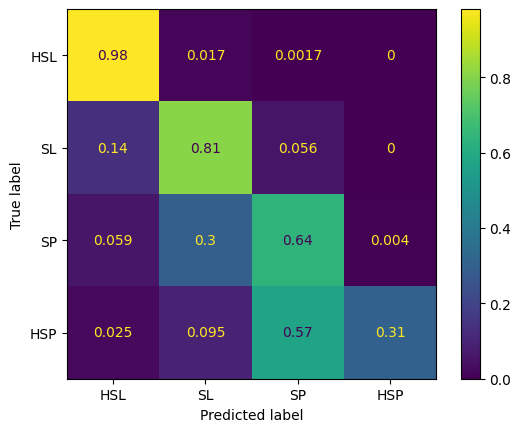

train metrics: {'num_unique_targets': 4, 'accuracy': 0.8880288600921631, 'speedup_slowdown_accuracy': 0.9906095266342163}


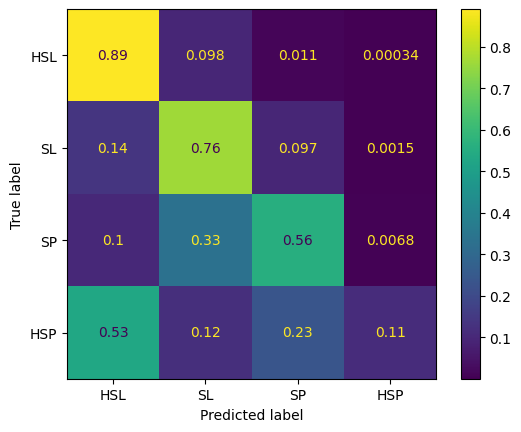

val metrics: {'num_unique_targets': 4, 'accuracy': 0.7923885583877563, 'speedup_slowdown_accuracy': 0.9832587242126465}


training_loss,▁
validation_loss,▁
training_loss,0.26084
validation_loss,0.56017


Loop groups stratified into Counter({'SL': 595, 'SP': 525, 'HSL': 416, 'HSP': 51})
Total loop groups: 1587 Train: 1269 Val: 318
768
56
44 loop groups removed for this split
768
56
7 loop groups removed for this split
Total datapoints: 69057 Train: 58783 Valid: 10274

 MLP(
  (projection): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (head): MLPHead(
    (head): Sequential(
      (0): Linear(in_features=312, out_features=156, bias=True)
      (1): BatchNorm1d(156, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=156, out_features=78, bias=True)
      (5): BatchNorm1d(78, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0.2, inplace=False)
      (8): Linear(in_features=78, out_features=39, bias=True)
      (9): BatchNorm1d(39, eps=1e-05

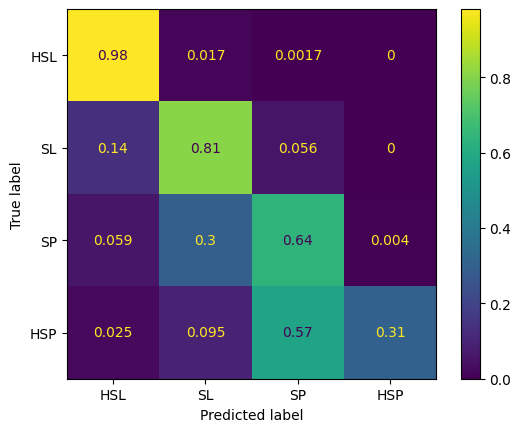

train metrics: {'num_unique_targets': 4, 'accuracy': 0.8880288600921631, 'speedup_slowdown_accuracy': 0.9906095266342163}


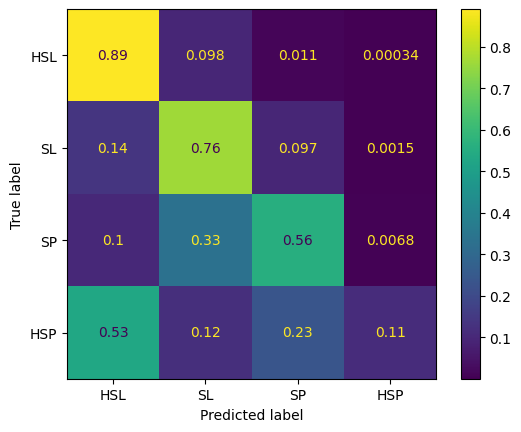

val metrics: {'num_unique_targets': 4, 'accuracy': 0.7923885583877563, 'speedup_slowdown_accuracy': 0.9832587242126465}


training_loss,▁
validation_loss,▁
training_loss,0.26084
validation_loss,0.56017


Loop groups stratified into Counter({'SL': 595, 'SP': 525, 'HSL': 416, 'HSP': 51})
Total loop groups: 1587 Train: 1269 Val: 318
768
56
44 loop groups removed for this split
768
56
7 loop groups removed for this split
Total datapoints: 69057 Train: 58783 Valid: 10274

 MLP(
  (projection): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (head): MLPHead(
    (head): Sequential(
      (0): Linear(in_features=312, out_features=156, bias=True)
      (1): BatchNorm1d(156, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=156, out_features=78, bias=True)
      (5): BatchNorm1d(78, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0.2, inplace=False)
      (8): Linear(in_features=78, out_features=39, bias=True)
      (9): BatchNorm1d(39, eps=1e-05

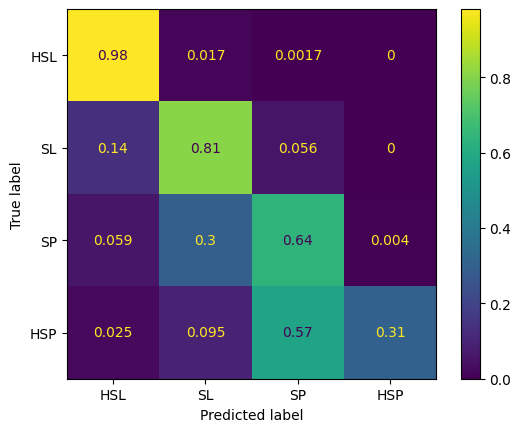

train metrics: {'num_unique_targets': 4, 'accuracy': 0.8880288600921631, 'speedup_slowdown_accuracy': 0.9906095266342163}


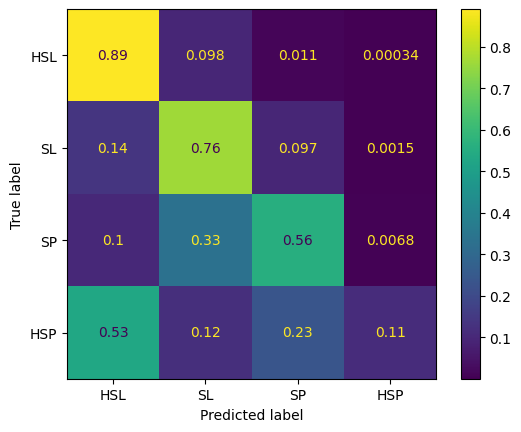

val metrics: {'num_unique_targets': 4, 'accuracy': 0.7923885583877563, 'speedup_slowdown_accuracy': 0.9832587242126465}


training_loss,▁
validation_loss,▁
training_loss,0.26084
validation_loss,0.56017


In [7]:
# cfg_data.update({
#     'benchmark': 'NPB',
#     'filters': [('benchmark', '==', 'NPB'), ('application', '==', 'SP')]
# })

runner = ExperimentRunner(cfg_data, device)
runner.run(
    project_name='MLFinal', 
    group_name='All, Experiment 5d', 
    run_name_prefix='exp5d_majority_strat_run',
    count=4
)

## Peform Analysis of the Data Set

In [ ]:
df = pd.read_csv(cfg_data['csv_path'])

# Print out how many data points and loop groups we have
print(f'Total data points: {len(df)}')
print(f'Number of loop groups: {len(df.groupby("id"))}')
print()

# Print out the number of data points per class
# class splits: [0, .7, 1, 1.5, 17]
for i in range(len(cfg_data['class_splits']) - 1):
    lower = cfg_data['class_splits'][i]
    upper = cfg_data['class_splits'][i + 1]
    num_points = len(df[(df['speedup_r'] >= lower) & (df['speedup_r'] < upper)])
    print(f'Number of data points with speedup between {lower} and {upper}: {num_points}, {num_points / len(df) * 100:.2f}%')

In [ ]:
# Count the number of data points per loop group
num_points_per_group = df.groupby('id').size()
print(f'Max number of data points per loop group: {num_points_per_group.max()}')
print(f'Min number of data points per loop group: {num_points_per_group.min()}')
print(f'Median number of data points per loop group: {num_points_per_group.median()}')
print(f'Mean number of data points per loop group: {num_points_per_group.mean()}')
print(f"Mode number of data points per loop group: {num_points_per_group.mode()[0]}")
print(f'Standard deviation of the number of data points per loop group: {num_points_per_group.std()}')

# Make a scatter plot of the number of data points per loop group
plt.scatter(range(len(num_points_per_group)), num_points_per_group)
plt.xlabel('Loop Group ID')
plt.ylabel('Number of Data Points')
plt.title('Number of Data Points per Loop Group')
plt.show()

In [ ]:
# Make a plot of the NPB benchmark applications. Show how many data points and loop groups are available for each application.
fig, ax = plt.subplots()
bar_plot = df[df['benchmark'] == 'NPB']['application'].value_counts().sort_index().plot(kind='bar', ax=ax)
ax.set_xlabel('Application')
ax.set_ylabel('Number of Data Points')
ax.set_title('Number of Data Points per NPB Benchmark Application')
ax.set_yscale('log')  # Set y-axis to logarithmic scale

# Add numbers at the top of each bar
for bar in bar_plot.patches:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom')

plt.show()

In [ ]:
# Create another plot, counting the number of unique loop ids in each application and do a similar bar chart
fig, ax = plt.subplots()
bar_plot = df[df['benchmark'] == 'NPB'].groupby('application')['id'].nunique().sort_index().plot(kind='bar', ax=ax, color='orange')
ax.set_xlabel('Application')
ax.set_ylabel('Number of Loop Groups')
ax.set_title('Number of Loop Groups per NPB Benchmark Application')

# Add numbers at the top of each bar
for bar in bar_plot.patches:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom')
    
plt.show()


In [ ]:
##########################################
# REQUIRES A SECOND LOOK
##########################################
class BidirectionalCrossAttention(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.n_embeddings = cfg['n_embeddings']
        self.projection = nn.Sequential(
            nn.Linear(cfg['emb_dim'], cfg['emb_latent_dim']),
            nn.LayerNorm(cfg['emb_latent_dim'])
        )
        latent_dim = cfg['emb_latent_dim'] * self.n_embeddings
        out_dim = 1 if cfg['task'] == 'regression' else cfg['num_classes']
        self.head = MLPHead(latent_dim+cfg['transf_dim'], out_dim, cfg['use_layer_norm'], cfg['dropout'], cfg['n_hid_layers'])
        self.cross_attention1 = nn.MultiheadAttention(embed_dim=latent_dim, num_heads=4, dropout=cfg['dropout'], batch_first=True, kdim=cfg['transf_dim'], vdim=cfg['transf_dim'])
        self.cross_attention2 = nn.MultiheadAttention(embed_dim=cfg['transf_dim'], num_heads=4, dropout=cfg['dropout'], batch_first=True, kdim=latent_dim, vdim=latent_dim)

    def forward(self, batch):
        emb_proj_1 = self.projection(batch[0])
        if self.n_embeddings == 1:
            features1, _ = self.cross_attention1(query=emb_proj_1, key=batch[1], value=batch[1])
            features2, _ = self.cross_attention2(query=batch[1], key=emb_proj_1, value=emb_proj_1)
            return self.head(torch.cat([emb_proj_1+features1, batch[1]+features2], dim=1)).squeeze(-1)
        elif self.n_embeddings == 2:
            emb_proj_2 = self.projection(batch[1])
            embs = torch.cat([emb_proj_1, emb_proj_2], dim=1)
            features1, _ = self.cross_attention1(query=embs, key=batch[2], value=batch[2])
            features2, _ = self.cross_attention2(query=batch[2], key=embs, value=embs)
            return self.head(torch.cat([embs+features1, batch[2]+features2], dim=1)).squeeze(-1)